In [ ]:
train_test_split!pip install category_encoders

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from category_encoders.ordinal import OrdinalEncoder

from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import NearMiss

from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             mean_absolute_error,
                             accuracy_score,
                             recall_score,
                             f1_score,
                             auc,
                             roc_auc_score, roc_curve, log_loss)



from sklearn.neighbors import (KNeighborsClassifier,
                               RadiusNeighborsClassifier)
from mlxtend.classifier import StackingClassifier


In [ ]:
df = pd.read_csv('data.csv')
df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


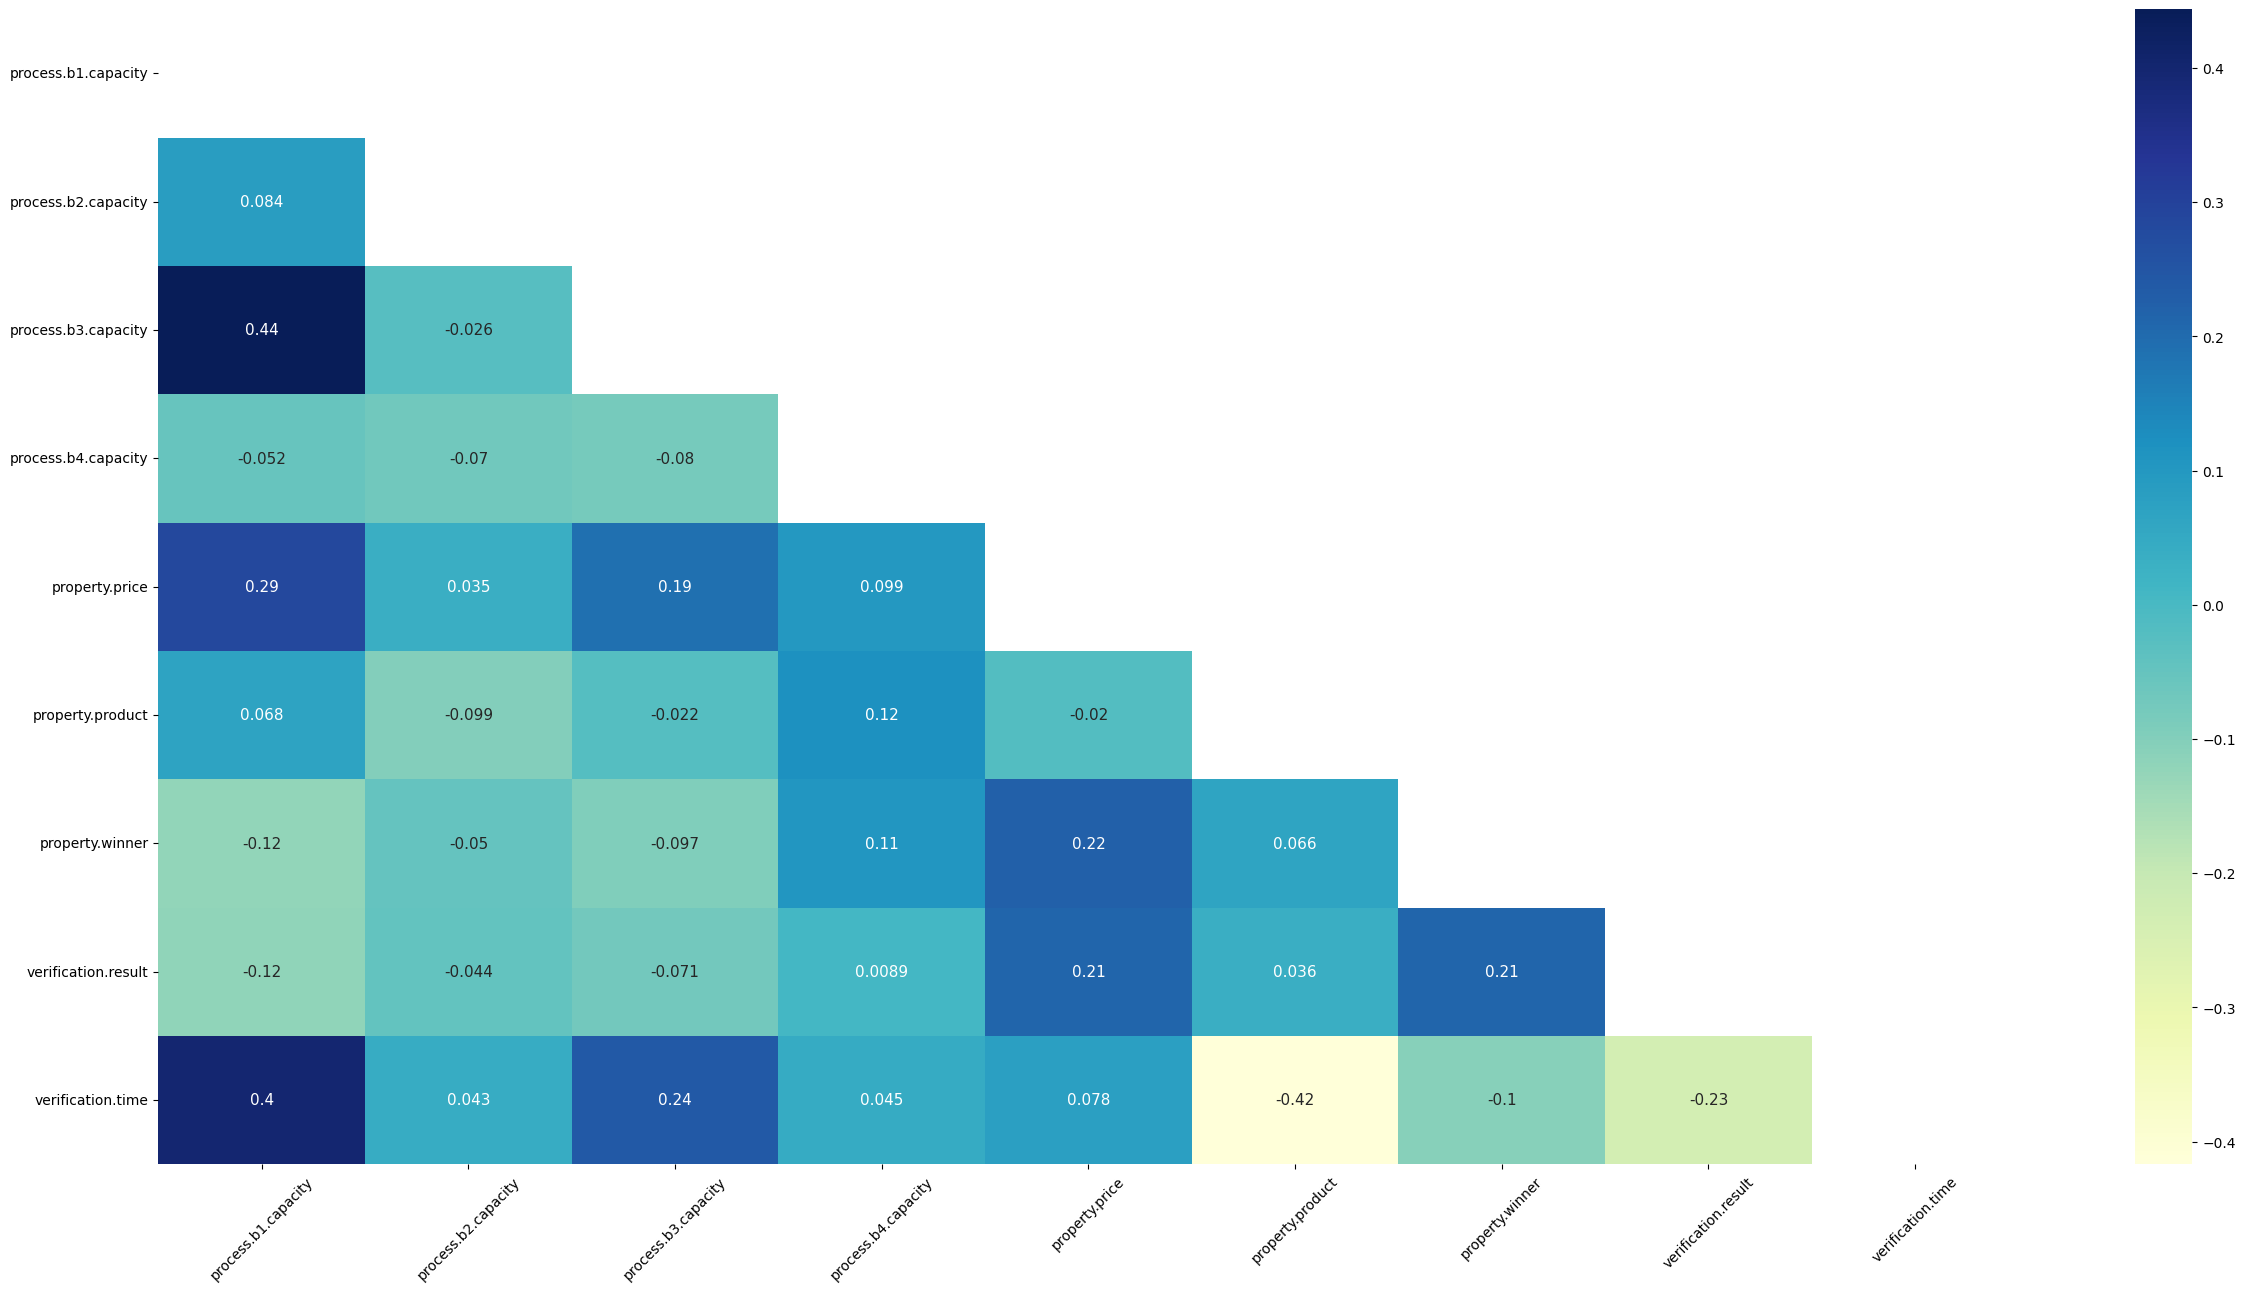

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(30, 15))
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

We see that dependence of features each to other is so small

In [ ]:
df['price_evaluation'] = df.apply(lambda x: 'expensive' if x['property.price'] > df['property.price'].mean() else 'cheap', axis=1)


In [ ]:
df['time_evaluation'] = df.apply(lambda x: 'slow' if x['verification.time'] > df['verification.time'].mean() else 'fast', axis=1)
df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time,price_evaluation,time_evaluation
0,0,0,2,1,59,1,0,False,163.316667,cheap,fast
1,0,0,2,1,59,2,0,False,200.860000,cheap,fast
2,0,0,2,1,59,4,0,False,154.888889,cheap,fast
3,0,0,2,1,59,6,0,False,108.640000,cheap,fast
4,0,0,2,1,60,1,0,True,85.466667,cheap,fast


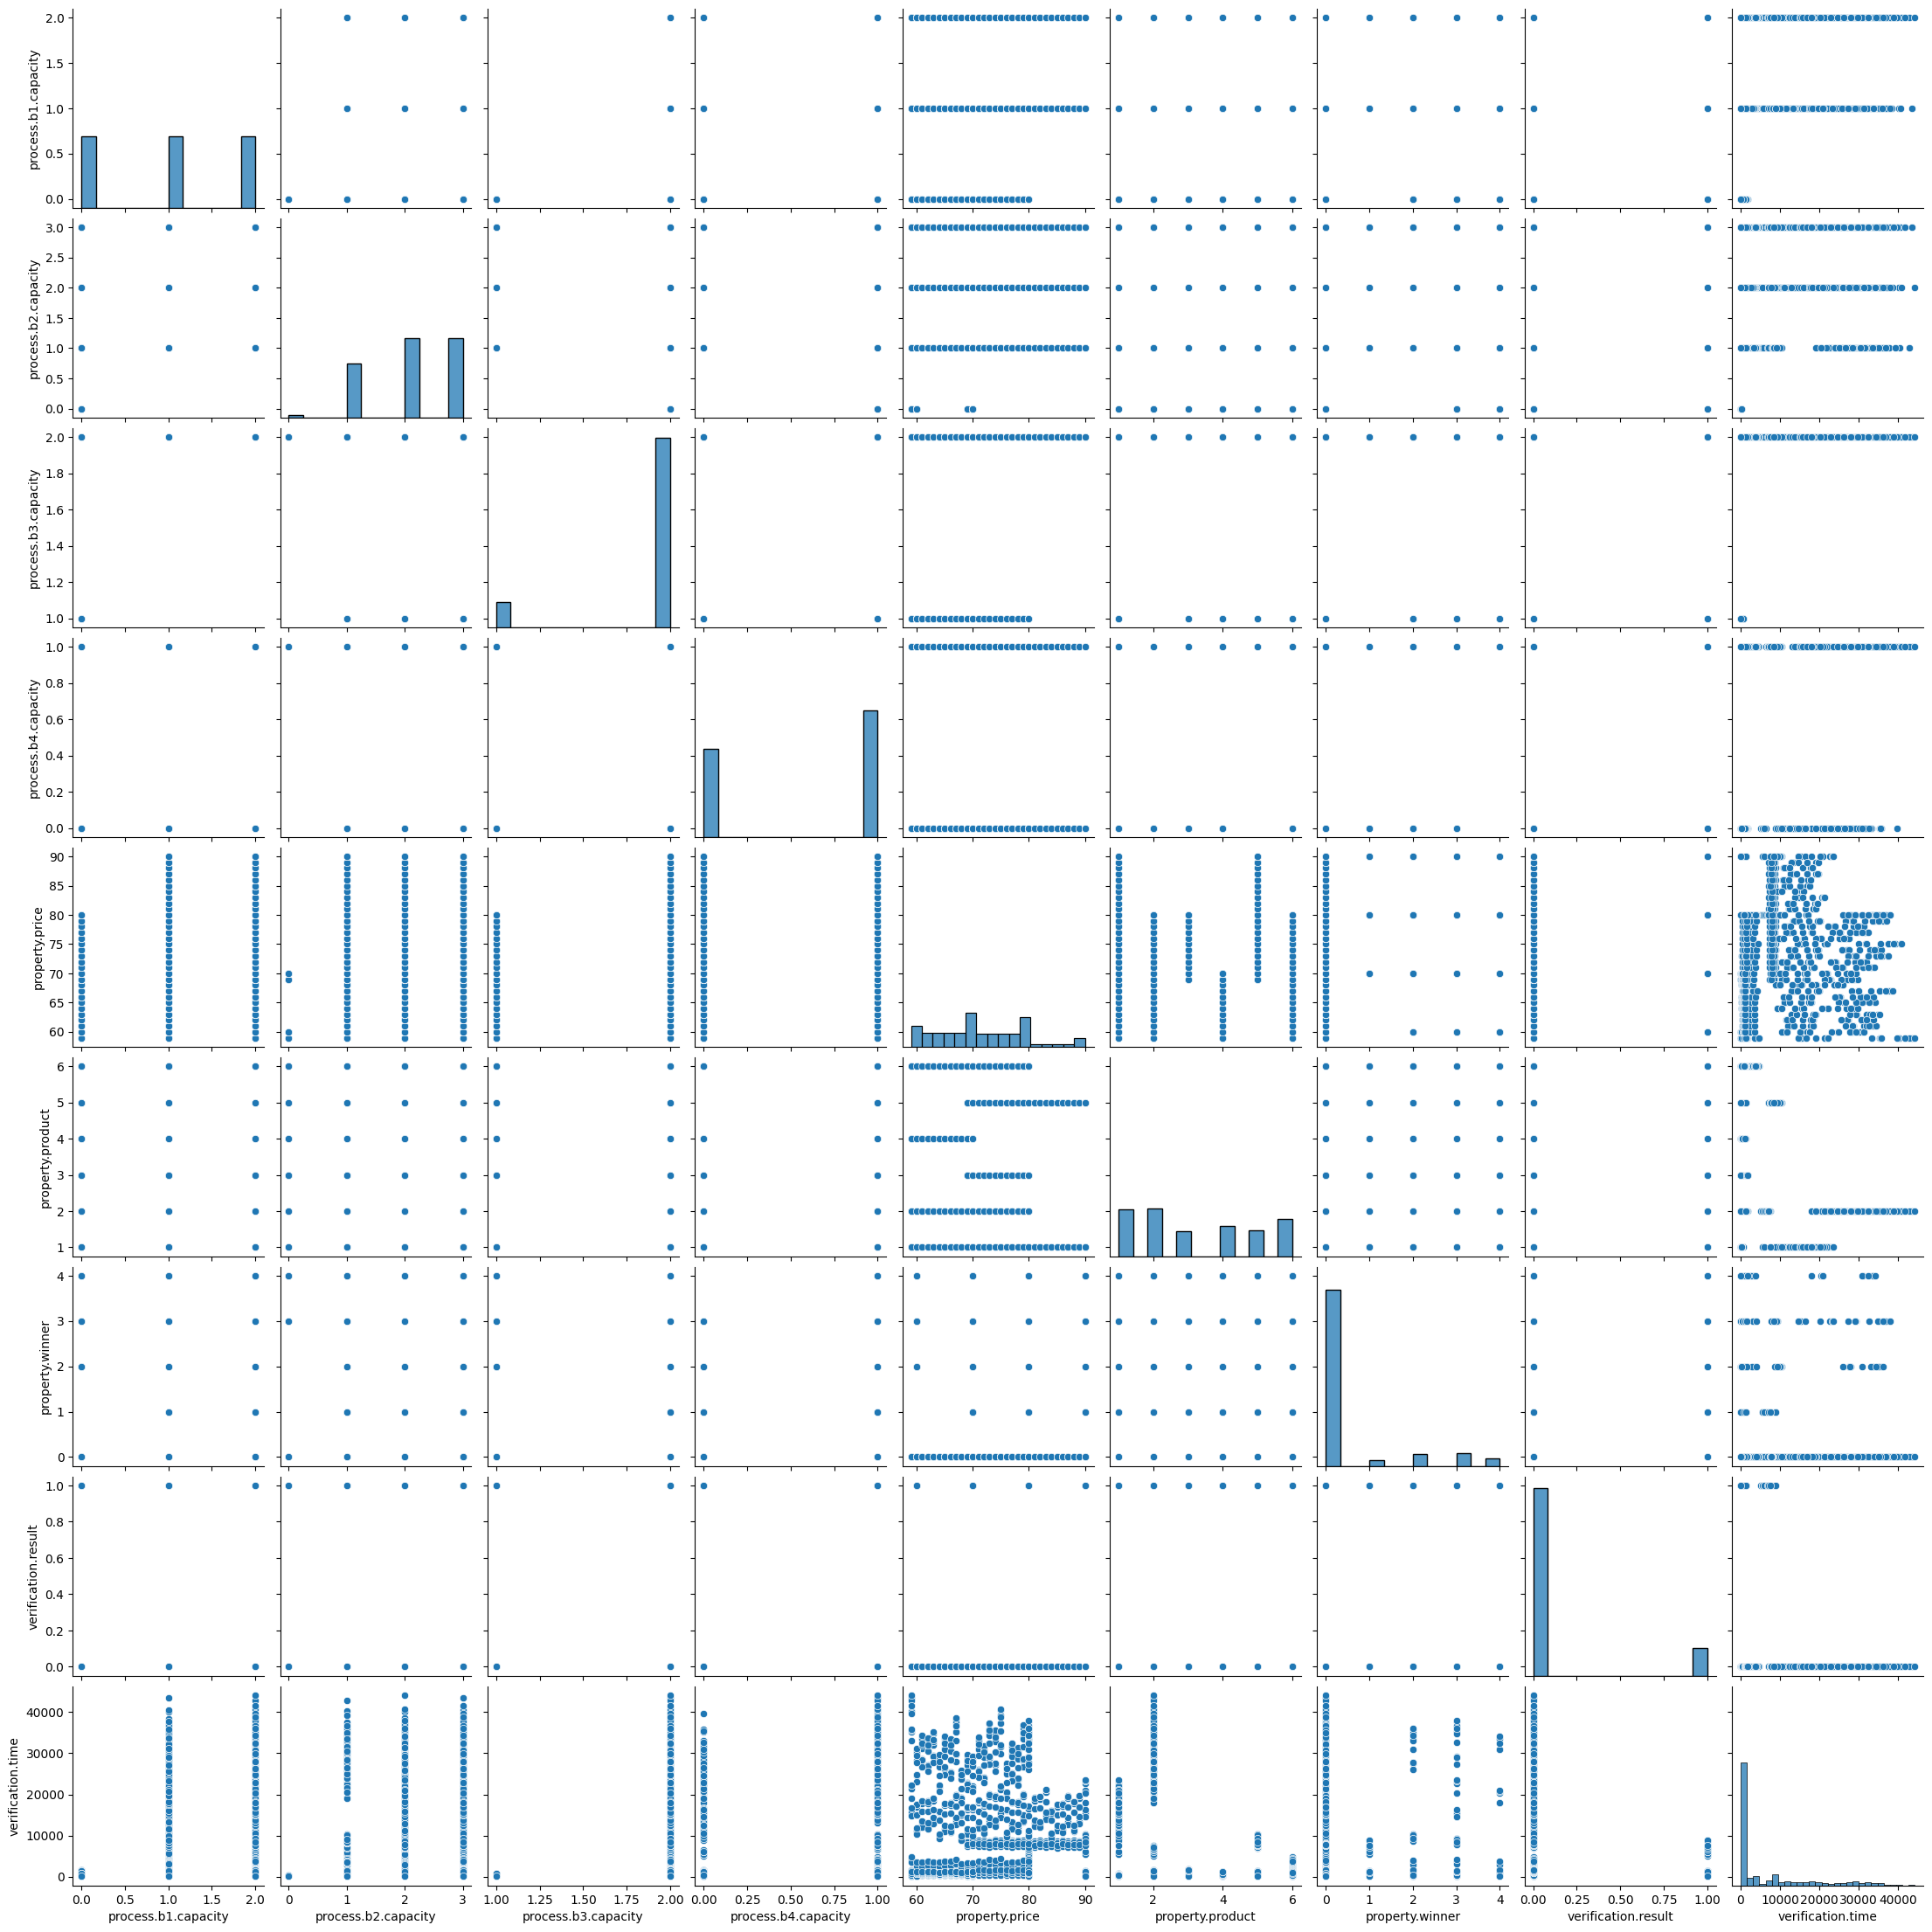

In [ ]:
sns.pairplot(data = df)

There are many outliers and distribution is asymmetric, so we are going to use RobustScaler

In [ ]:
corr_with_evaluation = corr_matrix['verification.time'].sort_values(ascending=False, key = lambda x: abs(x)).to_frame()
corr_with_evaluation.drop('verification.time')

,verification.time
property.product,-0.416841
process.b1.capacity,0.398359
process.b3.capacity,0.240032
verification.result,-0.232090
property.winner,-0.104274
property.price,0.078056
process.b4.capacity,0.044963
process.b2.capacity,0.042732


In [ ]:
top_features = corr_with_evaluation[abs(corr_with_evaluation['verification.time']) > 0.05].index.tolist()

In [ ]:
df_top_features = df[top_features].copy()

In [ ]:
enc = LabelEncoder()
df_top_features['verification.result'] = enc.fit_transform(df_top_features['verification.result'])
df_top_features.head()

,verification.time,property.product,process.b1.capacity,process.b3.capacity,verification.result,property.winner,property.price
0,163.316667,1,0,2,0,0,59
1,200.860000,2,0,2,0,0,59
2,154.888889,4,0,2,0,0,59
3,108.640000,6,0,2,0,0,59
4,85.466667,1,0,2,1,0,60


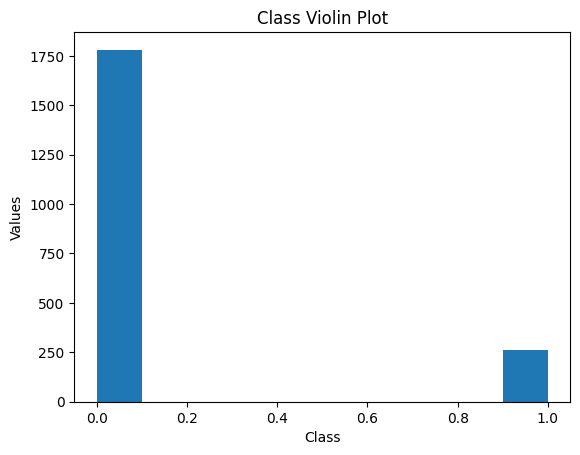

In [ ]:
plt.hist(x='verification.result', data=df_top_features)
plt.xlabel('Class')
plt.ylabel('Values')
plt.title('Class Violin Plot')
plt.show()

We see a huge difference between the repeatability of the two classes, so we will use SMOTEENN for balance

In [ ]:
X = df_top_features.loc[:, ~df_top_features.columns.isin(['verification.result'])]
y = df_top_features['verification.result']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: verification.result, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
smote_enn = SMOTEENN(random_state=0, smote=SMOTE(k_neighbors=5))
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [ ]:
knc = KNeighborsClassifier()
nb = GaussianNB()
knn = KNeighborsClassifier()
rn = RadiusNeighborsClassifier()
lr = LogisticRegression()
clf_stack = StackingClassifier(classifiers =[knc, nb, knn, rn], meta_classifier = lr)
model_stack = clf_stack.fit(X_train, y_train)
pred_stack = model_stack.predict(X_test)
accuracy = accuracy_score(y_test, pred_stack)
print('Accuracy score of Stacked model:', accuracy)

Accuracy score of Stacked model: 0.9674074074074074


In [ ]:
knc_params = {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']}
lr_params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
rn_params = {'radius': [0.5, 1.0, 1.5]}

knc = GridSearchCV(KNeighborsClassifier(), knc_params, cv=3)
knc.fit(X_train, y_train)

lr = GridSearchCV(LogisticRegression(), lr_params, cv=3)
lr.fit(X_train, y_train)

rn = GridSearchCV(RadiusNeighborsClassifier(), rn_params, cv=3)
rn.fit(X_train, y_train)

knc = knc.best_estimator_
lr = lr.best_estimator_
rn = rn.best_estimator_

clf_stack = StackingClassifier(classifiers =[knc, nb, knn, rn], meta_classifier = lr)
model_stack = clf_stack.fit(X_train, y_train)
pred_stack = model_stack.predict(X_test)
accuracy = accuracy_score(y_test, pred_stack)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 597, in predict
    probs = self.predict_proba(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 656, in predict_proba
    raise ValueError(
ValueError: No

In [ ]:
print('Accuracy score of Stacked model:', accuracy)

Accuracy score of Stacked model: 0.9881481481481481


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of Xgboost:', accuracy)

Accuracy score of Xgboost: 0.9911111111111112


In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=-1)
lgb_model.fit(X_train, y_train)
preds = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of LightGbmBoost:', accuracy)

Accuracy score of LGBBoost: 0.9911111111111112


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
import catboost as cb
cb_model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, max_depth=3, random_state=42)
cb_model.fit(X_train, y_train)
preds = cb_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of CatBoost:', accuracy)

0:	learn: 0.6249656	total: 46.6ms	remaining: 4.61s
1:	learn: 0.5696766	total: 47.7ms	remaining: 2.34s
2:	learn: 0.5227773	total: 48.1ms	remaining: 1.55s
3:	learn: 0.4797323	total: 48.5ms	remaining: 1.16s
4:	learn: 0.4478169	total: 48.8ms	remaining: 928ms
5:	learn: 0.4158871	total: 49.1ms	remaining: 770ms
6:	learn: 0.3910527	total: 49.4ms	remaining: 657ms
7:	learn: 0.3674470	total: 49.8ms	remaining: 572ms
8:	learn: 0.3434467	total: 50.2ms	remaining: 507ms
9:	learn: 0.3262893	total: 50.5ms	remaining: 455ms
10:	learn: 0.3068453	total: 50.9ms	remaining: 412ms
11:	learn: 0.2911074	total: 55.9ms	remaining: 410ms
12:	learn: 0.2757040	total: 56.3ms	remaining: 377ms
13:	learn: 0.2615569	total: 56.7ms	remaining: 348ms
14:	learn: 0.2503975	total: 57ms	remaining: 323ms
15:	learn: 0.2404022	total: 57.4ms	remaining: 302ms
16:	learn: 0.2327668	total: 57.8ms	remaining: 282ms
17:	learn: 0.2227864	total: 58.3ms	remaining: 265ms
18:	learn: 0.2123336	total: 60ms	remaining: 256ms
19:	learn: 0.2034541	total

In [ ]:
xgb_model = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)

best_model = xgb_grid.best_estimator_
preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of XGBoost via grid:', accuracy)

Accuracy score of XGBoost via grid: 0.9911111111111112


In [ ]:
lgb_model = lgb.LGBMClassifier(verbosity=-1)
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
lgb_grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
lgb_grid.fit(X_train, y_train)

best_model = lgb_grid.best_estimator_
preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of LightGMB via grid:', accuracy)

Accuracy score of LightGMB via grid: 0.9911111111111112


In [ ]:
cb_model = cb.CatBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
cb_grid = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=3, scoring='accuracy')
cb_grid.fit(X_train, y_train)

best_model = cb_grid.best_estimator_
preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of CatBoost via grid:', accuracy)

Показано результат, скорочений до останніх рядків (5000).
51:	learn: 0.1174091	total: 22.3ms	remaining: 42ms
52:	learn: 0.1157466	total: 22.6ms	remaining: 41.3ms
53:	learn: 0.1138033	total: 22.9ms	remaining: 40.7ms
54:	learn: 0.1117020	total: 23.3ms	remaining: 40.2ms
55:	learn: 0.1095543	total: 23.6ms	remaining: 39.6ms
56:	learn: 0.1086458	total: 23.9ms	remaining: 38.9ms
57:	learn: 0.1079715	total: 24.2ms	remaining: 38.4ms
58:	learn: 0.1061121	total: 24.5ms	remaining: 37.8ms
59:	learn: 0.1047329	total: 24.8ms	remaining: 37.2ms
60:	learn: 0.1042461	total: 25.2ms	remaining: 36.7ms
61:	learn: 0.1026171	total: 25.5ms	remaining: 36.1ms
62:	learn: 0.1019096	total: 25.8ms	remaining: 35.6ms
63:	learn: 0.1005175	total: 26.1ms	remaining: 35.1ms
64:	learn: 0.1000157	total: 26.4ms	remaining: 34.5ms
65:	learn: 0.0975092	total: 26.7ms	remaining: 34ms
66:	learn: 0.0969740	total: 27ms	remaining: 33.5ms
67:	learn: 0.0960354	total: 27.3ms	remaining: 32.9ms
68:	learn: 0.0947273	total: 27.6ms	remaining: 3

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score of BaggingClassifier:', accuracy)

Accuracy score of BaggingClassifier: 0.9896296296296296


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
}
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier())
bc_grid = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=3, scoring='accuracy')
bc_grid.fit(X_train, y_train)

best_model = bc_grid.best_estimator_
preds = best_model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print('Accuracy score of BaggingClassifier via grid:', accuracy)

Learning rate set to 0.154489
0:	learn: 0.5999499	total: 1.06ms	remaining: 52ms
1:	learn: 0.5299606	total: 5.64ms	remaining: 135ms
2:	learn: 0.4658151	total: 9.4ms	remaining: 147ms
3:	learn: 0.4201329	total: 17.3ms	remaining: 198ms
4:	learn: 0.3779053	total: 18.6ms	remaining: 168ms
5:	learn: 0.3398187	total: 19.8ms	remaining: 145ms
6:	learn: 0.3113557	total: 21.1ms	remaining: 130ms
7:	learn: 0.2820619	total: 23.3ms	remaining: 122ms
8:	learn: 0.2647241	total: 25.5ms	remaining: 116ms
9:	learn: 0.2491476	total: 33.4ms	remaining: 134ms
10:	learn: 0.2319863	total: 34.7ms	remaining: 123ms
11:	learn: 0.2118257	total: 35.9ms	remaining: 114ms
12:	learn: 0.2014945	total: 38.4ms	remaining: 109ms
13:	learn: 0.1904798	total: 40ms	remaining: 103ms
14:	learn: 0.1830226	total: 42.1ms	remaining: 98.3ms
15:	learn: 0.1739416	total: 50.3ms	remaining: 107ms
16:	learn: 0.1664900	total: 51.7ms	remaining: 100ms
17:	learn: 0.1566584	total: 52.9ms	remaining: 94.1ms
18:	learn: 0.1473511	total: 54.5ms	remaining: 